# Joint project AMD + SM2L

https://docs.google.com/document/d/1oqoIyRUI_digfIokf53fox0I1eWiTFzQaae-PxMre0Y/edit

The task is to implement from scratch a learning algorithm for **regression** with **square loss** (e.g., **ridge regression**). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:
- PERNP (Person's earnings)
- PINCP (Person's income)
- WAGP (Wages or salary income past 12 months)
- HINCP (Household income)
- FINCP (Family income)

This code is run inside the Docker container provided in the course.

## Dataset

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [2]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_252
Branch HEAD
Compiled by user centos on 2020-02-02T19:38:06Z
Revision cee4ecbb16917fa85f02c635925e2687400aa56b
Url https://gitbox.apache.org/repos/asf/spark.git
Type --help for more information.


In [3]:
import os, zipfile, json, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import udf, isnan, when, count, col, mean, stddev
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler, Imputer, PCA
from pyspark.ml.stat import Summarizer, Correlation
from pyspark.mllib.regression import LabeledPoint
%matplotlib inline

def download_dataset():
    """
    Checks if the dataset has already been downloaded and, if not, downloads and unzips it.
    """
    
    if (os.path.exists('./data/2013-american-community-survey/ss13husa.csv') and
        os.path.exists('./data/2013-american-community-survey/ss13husb.csv') and 
        os.path.exists('./data/2013-american-community-survey/ss13pusa.csv') and
        os.path.exists('./data/2013-american-community-survey/ss13pusb.csv')):
        print('Data already downloaded.')
        return
    
    print('Downloading the dataset...')
    os.system('mkdir ./data')
    os.system('kaggle datasets download census/2013-american-community-survey -p ./data')

    print('Unzipping the dataset...')
    with zipfile.ZipFile("./data/2013-american-community-survey.zip","r") as zip_ref:
        zip_ref.extractall(path)

    print('DONE! Data have been extracted in dir {}.'.format(path))

def plot_na_distribution(null_df):
    """
    Plots the distribution of missing values in features in the training set.
    
    Args:
        nul_df (PySpark DataFrame): DataFrame containing the fraction of missing values for each feature.
    """
    
    null_dict = null_df.take(1)[0].asDict()
    null_distr = [null_dict[k] for k in null_dict.keys()]
    
    sns.set_style("white")
    
    plt.figure(num = None, figsize = (12, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')
    g = sns.histplot(null_distr, bins = 40, color = "r")
    plt.suptitle('Distribution of missing values in training set', fontsize = 20)
    plt.xlabel("Fraction of missing values", fontsize = 14)
    plt.ylabel("Number of features", fontsize = 14)
    #plt.savefig('images/na_distr.png')

def raw_label_stats(transformed_train_df, label):
    """
    Computes some stats on the raw label data, such as the minimum and the maximum values, the mean and the
        standard deviation, in order to revert the scaling process.
        
    Args:
        transformed_train_df (PySpark DataFrame): DataFrame containing a single column of features vectors
            belonging to the training points.
        label (string): Name of the feature to be predicted.
        
    Returns:
        Dictionary: Dictionary containng the minimum, the maximum, the mean and the standard deviation of the
            label raw values.
    """
    
    # We should save max and min label (if we use MinMaxScaler).
    # We should save mean and standard deviation (if we use StandardSacaler).
    stats_df = transformed_train_df.select(Summarizer.metrics("min", "max", "mean", "variance")
                                       .summary(transformed_train_df['label']))
    stats = stats_df.take(1)[0]
    
    label_stats = dict()
    label_stats["min"] = stats[0][0][0]
    label_stats["max"] = stats[0][1][0]
    label_stats["mean"] = stats[0][2][0]
    label_stats["std"] = math.sqrt(stats[0][3][0])
    
    print("{} stats:".format(label))
    print(label_stats)
    
    return label_stats
    
def plot_corr_matrix(corr_matrix, scheme):
    """
    Plots the correlation matrix between the features in training set.
    
    Args:
        corr_matrix (list of lists of floats): matrix containing the values of the correlation for each
            coupple of attributes.
        scheme (list of strings): list containing the names of the features.
    """
    
    corr_df = pd.DataFrame(corr_matrix)
    corr_df.columns = scheme
    d = dict()
    for i in range(len(scheme)):
        d[i] = scheme[i]

    corr_df.rename(d, inplace=True)

    sns.set(rc = {'figure.figsize':(15,13)})
    sns_plot = sns.heatmap(corr_df)
    #sns_plot.savefig("images/corr_matrix.png")
    
def parse_point(row, intercept = True):
    """
    Converts a row of a pyspark dataframe into a LabeledPoint.
    
    Args:
        row (PySpark DataFrame row): Row of a DataFrame composed by an array of features, an array containing
            the label, an array of scaled features, an array containing the scaled label and an array
            containing the values found by PCA and a double corresponding to the value to be predicted.
        intercept (boolean): If True, a feature with a constant value 1 is added in order to learn also
            the value of the intercept.

    Returns:
        LabeledPoint: The line is converted into a LabeledPoint, which consists of a label and
            features.
    """
    
    row_dict = row.asDict()
    label_value = np.array(row_dict['scaledLabel'])[0]
    feature_list = np.array(row_dict['pcaFeatures']).tolist()
    
    if intercept: feature_list.insert(0, 1.0)
    
    return LabeledPoint(label_value, feature_list)
    
def preprocess(train_df, test_df, val_df, na_threshold, label, n_features, data_type, imputer_strategy = 'mean'):
    """
    Preprocess a PySpark DataFrame, dropping the categorical feature and the discarded labels,
        casting the remaining features in double, dealing with null values with imputation and 
        dropping the features with too many missing values, dropping also all the data points
        with missing label. Optionally, scales all the features of the DataFrame.
        
    Note:
        Feature scaling can slow up the process if the DataFrame is huge.

    Args:
        train_df (PySpark DataFrame): Portion of the DataFrame read by the csv file, corresponding to the
            training set.
        test_df (PySpark DataFrame): Portion of the DataFrame read by the csv file, corresponding to the test
            set.
        val_df (PySpark DataFrame): Portion of the DataFrame read by the csv file, corresponding to the
            validation set.
        na_threshold (float between 0 and 1): Threshold that establish if a feature should be dropped or not
            based on its percentage of null values.
        label (string): Feature that corresponds to the chosen label to be predicted.
        n_features (int): Number of features we want to obtain after we apply the PCA dimensionality reduction
            strategy.
        data_type (string): It can be `p` if the label to be predicted belongs to the person dataset, or `h`
            if the label belongs to the household dataset.
        imputer_strategy (string): It can be `mean` or `median`, based on the imputation strategy we choose.

    Returns:
        PySpark DataFrame: Restult of the processing of the original DataFrame.
    """    
    
    print("Dropping features...")
    train_df = train_df.drop('RT')
    test_df = test_df.drop('RT')
    val_df = val_df.drop('RT')
    
    possible_labels = ['PERNP', 'PINCP', 'WAGP'] if data_type == 'p' else ['HINCP', 'FINCP']  
    possible_labels.remove(label)
    
    for i in possible_labels:
        train_df = train_df.drop(i)
        test_df = test_df.drop(i)
        val_df = val_df.drop(i)

    print("Casting features to float...")    
    train_df = train_df.select([col(c).cast("float") for c in train_df.columns])
    test_df = test_df.select([col(c).cast("float") for c in test_df.columns])
    val_df = val_df.select([col(c).cast("float") for c in val_df.columns])
    
    print('Dropping data points with null label...')
    train_df = train_df.filter(train_df[label].isNotNull()) 
    test_df = test_df.filter(test_df[label].isNotNull())
    val_df = val_df.filter(val_df[label].isNotNull())
        
    print("Dropping features with more than {}% null values...".format(int(na_threshold * 100)))
    n = train_df.count()
    null_df = train_df.select([(count(when(col(c).isNull(), c))/n).alias(c) for c in train_df.columns])
    
    # Uncomment the following line to plot the distribution of null values in training features.
    #plot_na_distribution(null_df)
    
    scheme = train_df.columns
    null_distr = null_df.take(1)[0].asDict().values()
    
    for i in np.where(np.array(list(null_distr)) > na_threshold)[0]:
        train_df = train_df.drop(scheme[i])
        test_df = test_df.drop(scheme[i])
        val_df = val_df.drop(scheme[i])
        
    print('We reduced the number of features to {}.'.format(len(train_df.columns)))  

    print('Imputing missing values...')    
    imputer = Imputer()
    imputer.setInputCols(train_df.columns)
    imputer.setOutputCols(train_df.columns)
    imputer.setStrategy(imputer_strategy)

    imputer = imputer.fit(train_df)
    
    train_df = imputer.transform(train_df)
    test_df = imputer.transform(test_df)
    val_df = imputer.transform(val_df)
    
    # Uncomment the following lines to filter out data points with outlier values for the specified features.
    # BE CAREFUL! If a lot of features are considered, a lot of data points will be removed from the dataset.
    #print("Dropping outliers...")
    #features_to_filter = [label]
    
    #for i in range(len(features_to_filter)):
    #    quantiles = train_df.approxQuantile(features_to_filter[i], [0.25, 0.75], 0.1)
    #    iqr = quantiles[1] - quantiles[0]
        
        # If iqr is 0, it means that all the data points assume the same value for this feature.
    #    if iqr != 0:
    #        train_df = train_df.filter(col(features_to_filter[i]) < (quantiles[1] + 1.5 * iqr))
    #        train_df = train_df.filter(col(features_to_filter[i]) > (quantiles[0] - 1.5 * iqr))
    #        test_df = test_df.filter(col(features_to_filter[i]) < (quantiles[1] + 1.5 * iqr))
    #        test_df = test_df.filter(col(features_to_filter[i]) > (quantiles[0] - 1.5 * iqr))
    #        val_df = val_df.filter(col(features_to_filter[i]) < (quantiles[1] + 1.5 * iqr))
    #        val_df = val_df.filter(col(features_to_filter[i]) > (quantiles[0] - 1.5 * iqr))

    scheme = train_df.columns
    scheme.remove(label)
    
    assembler = VectorAssembler(inputCols = scheme, outputCol = 'features')
    transformed_train_df = assembler.transform(train_df).select(['features', label])
    transformed_test_df = assembler.transform(test_df).select(['features', label])
    transformed_val_df = assembler.transform(val_df).select(['features', label])

    # Uncomment the following lines to compute the correlation matrix.
    # (Only for explorative task, the correlation will be handled with PCA)
    #print("Finding features with high correlation...")
    #matrix = Correlation.corr(transformed_train_df, "features").collect()[0][0]
    #corr_matrix = matrix.toArray().tolist()
    #plot_corr_matrix(corr_matrix, scheme)
    
    # Uncomment the following lines to print the coupples of attributes with high positive or negative correlation
    #print("Highly positive correlated features:")
    #positive_corr = [[print(scheme[i], scheme[j], corr_matrix[j][i]) for j in range(len(corr_matrix[i])) 
    #                  if i != j and corr_matrix[j][i] > .9] for i in range(len(corr_matrix))]
    #print("Highly negative correlated features:")
    #negative_corr = [[print(scheme[i], scheme[j], corr_matrix[j][i]) for j in range(len(corr_matrix[i])) 
    #                  if i != j and corr_matrix[j][i] < -.9] for i in range(len(corr_matrix))]
    
    assembler_lbl = VectorAssembler(inputCols = [label], outputCol = 'label')
    transformed_train_df = assembler_lbl.transform(transformed_train_df).select(['features', 'label'])
    transformed_test_df = assembler_lbl.transform(transformed_test_df).select(['features', 'label'])
    transformed_val_df = assembler_lbl.transform(transformed_val_df).select(['features', 'label'])
    
    label_stats = raw_label_stats(transformed_train_df, label)
    
    print("Feature scaling...")
    #scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures').fit(transformed_train_df)
    scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaledFeatures').fit(transformed_train_df)
    transformed_train_df = scaler.transform(transformed_train_df)
    transformed_test_df = scaler.transform(transformed_test_df)
    transformed_val_df = scaler.transform(transformed_val_df)
    
    #scaler_lbl = StandardScaler(inputCol = 'label', outputCol = 'scaledLabel').fit(transformed_train_df)
    scaler_lbl = MinMaxScaler(inputCol = 'label', outputCol = 'scaledLabel').fit(transformed_train_df)
    transformed_train_df = scaler_lbl.transform(transformed_train_df)
    transformed_test_df = scaler_lbl.transform(transformed_test_df)
    transformed_val_df = scaler_lbl.transform(transformed_val_df)
    
    print('Applying PCA for dimensionality reduction...')
    pca = PCA(k = n_features, inputCol = 'scaledFeatures', outputCol = 'pcaFeatures').fit(transformed_train_df)
    transformed_train_df = pca.transform(transformed_train_df)
    transformed_test_df = pca.transform(transformed_test_df)
    transformed_val_df = pca.transform(transformed_val_df)
    print('Explained Variance Ratio\n', pca.explainedVariance.toArray())
    
    #pcs = np.round(pca.pc.toArray(),4)
    
    print('Transforming each data point in a LabeledPoint...')
    parsed_train_data = transformed_train_df.rdd.map(lambda s: parse_point(s))
    parsed_test_data = transformed_test_df.rdd.map(lambda s: parse_point(s))
    parsed_val_data = transformed_val_df.rdd.map(lambda s: parse_point(s))

    print("DONE!")
        
    return parsed_train_data, parsed_test_data, parsed_val_data, label_stats

def save_preprocessed_rdd(rdd, filename):
    """
    Saves the rdd on disk as a file.
    
    Note:
        This operation can be really slow. It should be done once and only in case of multiple executions
            of the learning code, in order to avoid to recompute the preprocessing every time.
    
    Args:
        rdd (PySpark RDD): RDD that has to be saved on disk.
        filename (String): Name of the file to be saved.
    """
    
    print("Saving preprocessed data...")
    base_dir = os.path.join('./data')
    input_path = os.path.join(filename)
    file_name = os.path.join(base_dir, input_path)

    rdd.saveAsTextFile(file_name)

def parse_line(line):
    """
    Converts one line of a saved preprocessed data file in a LabledPoint.
    
    Args: 
        line (String): A line of the file.
    
    Returns:
        LabeledPoint: LabeledPoint corresponding to the line in input.
    """
    
    label_value, feature_list = (line.strip()[1:-1]).split(',', 1)
    
    return LabeledPoint(float(label_value), [float(i) for i in feature_list[1:-1].split(',')])
    
def load_preprocessed_datasets():
    """
    Loads preprocessed data from disk.
    
    Returns:
        RDD of LabeledPoints: RDD containing the saved preprocessed training set.
        RDD of LabeledPoints: RDD containing the saved preprocessed test set.
        RDD of LabeledPoints: RDD containing the saved preprocessed validation set.
        Dictionary: Dictionary containing some statistics about the raw values of the label.
    """
    
    print('Reading the preprocessed saved dataset...')
    base_dir = os.path.join('./data')
    input_path_train = os.path.join('preprocessed_train_set')
    input_path_test = os.path.join('preprocessed_test_set')
    input_path_val = os.path.join('preprocessed_val_set')
    file_name_train = os.path.join(base_dir, input_path_train)
    file_name_test = os.path.join(base_dir, input_path_test)
    file_name_val = os.path.join(base_dir, input_path_val)

    parsed_train_data = sc.textFile("./data/preprocessed_train_set").map(lambda l: parse_line(l))
    parsed_test_data = sc.textFile("./data/preprocessed_test_set").map(lambda l: parse_line(l))
    parsed_val_data = sc.textFile("./data/preprocessed_val_set").map(lambda l: parse_line(l))
        
    label_stats = dict()
        
    with open('./data/label_stats.json', 'r') as f:
        label_stats = json.load(f)

    return parsed_train_data, parsed_test_data, parsed_val_data, label_stats
    
def get_datasets(sqlContext, label, n_features):
    """
    Loads preprocessed data from disk. If there are no already preprocessed data on disk, donwloads
        the dataset and preprocesses it.
        
    Args:
        sqlContext (PySpark SQLContext): PySpark SQL entry point, needed in order to create PySpark DataFrames.
        label (string): Name of the feature chosen as the label to be predicted.
        n_features (int): Number of features we want to obtain after the execution of the PCA algorithm for 
            dimensionality reduction.
        
    Returns:
        Returns:
        RDD of LabeledPoints: RDD containing the saved preprocessed training set.
        RDD of LabeledPoints: RDD containing the saved preprocessed test set.
        RDD of LabeledPoints: RDD containing the saved preprocessed validation set.
        Dictionary: Dictionary containing some statistics about the raw values of the label.
    """
    
    if (os.path.exists('./data/preprocessed_train_set') and
        os.path.exists('./data/preprocessed_train_set') and
        os.path.exists('./data/preprocessed_train_set')):
        return load_preprocessed_datasets()
    else:
        download_dataset() 
        
        data_type = 'p' if label in ['PERNP', 'PINCP', 'WAGP'] else 'h'
        
        print('Reading the dataset...')        
        base_dir = os.path.join('./data/2013-american-community-survey')
        input_path_a = os.path.join('ss13pusa.csv') if data_type == 'p' else os.path.join('ss13husa.csv')
        input_path_b = os.path.join('ss13pusb.csv') if data_type == 'p' else os.path.join('ss13husb.csv')
        file_name_a = os.path.join(base_dir, input_path_a)
        file_name_b = os.path.join(base_dir, input_path_b)

        df_a = sqlContext.read.csv(file_name_a, header = True)
        df_b = sqlContext.read.csv(file_name_b, header = True)

        df = df_a.union(df_b)
        
        n = df.count()
        header_list = df.columns
        print("Number of columns: {}\nNumber of rows: {}".format(len(header_list), n))
        
        print('Subdividing data into train, validation and test set...')
        weights = [.8, .1, .1]
        seed = 12345

        #df = df.sample(False, .00001)
        train_df, test_df, val_df = df.randomSplit(weights, seed = seed)
        
        na_threshold = .6
        print('Preprocessing with\n\tthreshold = {},\n\tlabel = {}\n...'.format(na_threshold, label))
        parsed_train_data, parsed_test_data, parsed_val_data, label_stats = preprocess(train_df, test_df,
                                                            val_df, na_threshold, label, n_features, data_type)
        
        # Change the following variable in True to save the preprocessed data
        # This has to be done in order to avoid re-preprocessing data in developing phase
        # BE CAREFUL! Saving data can take a lot of time
        save_preprocessed_data = False
        if save_preprocessed_data == True:
            save_preprocessed_rdd(parsed_train_data, "preprocessed_train_set")
            save_preprocessed_rdd(parsed_test_data, "preprocessed_test_set")
            save_preprocessed_rdd(parsed_val_data, "preprocessed_val_set")
            
            with open("./data/label_stats.json", "w") as f:
                json.dump(label_stats, f) 
            
        return parsed_train_data, parsed_test_data, parsed_val_data, label_stats
    
def real_label_minmax(scaled_lbl, lbl_stats):
    """
    Converts a label scaled with the MinMaxScaler into a label in USD.

    Note:
        The variable ADJINC (Adjustment factor for income and earnings dollar amounts) is necessary to
            adjusts reported income to 2013 dollars.

    Args:
        scaled_lbl (float): MinMax scaled value for the feature choosen as label.
        lbl_stats (dictionary): Dictionary containing some stats relative to the raw values of the label
            such as the minimum and the maximum value.

    Returns:
        float: Value for the choosen label measured in USD. It is obtained by reversing the
            normalization formula.
    """
    ADJINC * 1.007549
    
    return round(((lbl_stats["max"] - lbl_stats["min"]) * scaled_lbl + lbl_stats["min"]) * ADJINC, 0)

def real_label_standard(scaled_lbl, lbl_stats):
    """
    Converts a label scaled with the StandardScaler into a label in USD.
    
    Note:
        The variable ADJINC (Adjustment factor for income and earnings dollar amounts) is necessary to
            adjusts reported income to 2013 dollars.

    Args:
        scaled_lbl (float): Standard scaled value for the feature choosen as label.
        lbl_stats (dictionary): Dictionary containing some stats relative to the raw values of the label
            such as the mean and the standard deviation.

    Returns:
        float: Value for the choosen label measured in USD. It is obtained by reversing the
            normalization formula.
    """
    ADJINC * 1.007549
    
    return round((lbl_stats["std"] * scaled_lbl + lbl_stats["mean"]) * ADJINC, 0)

In [4]:
label = 'HINCP'
n_features = 30

parsed_train_data, parsed_test_data, parsed_val_data, label_stats = get_datasets(sqlContext, label, n_features)
parsed_train_data.cache()
parsed_test_data.cache()
parsed_val_data.cache()

Reading the preprocessed saved dataset...


PythonRDD[8] at RDD at PythonRDD.scala:53

### Data representation

The feature vector we obtain after applying PCA contains the features ordered by they variance in the map space. So, we can take the first two features (ignoring the added feature for the intercept) and plot the data points in a two dimetional data space, possibly colouring the points depending on the value of the label.

In [6]:
sample_data = parsed_train_data.take(3000)

In [7]:
xs = [i.features[1] for i in sample_data]
ys = [i.features[2] for i in sample_data]
ls = [i.label for i in sample_data]

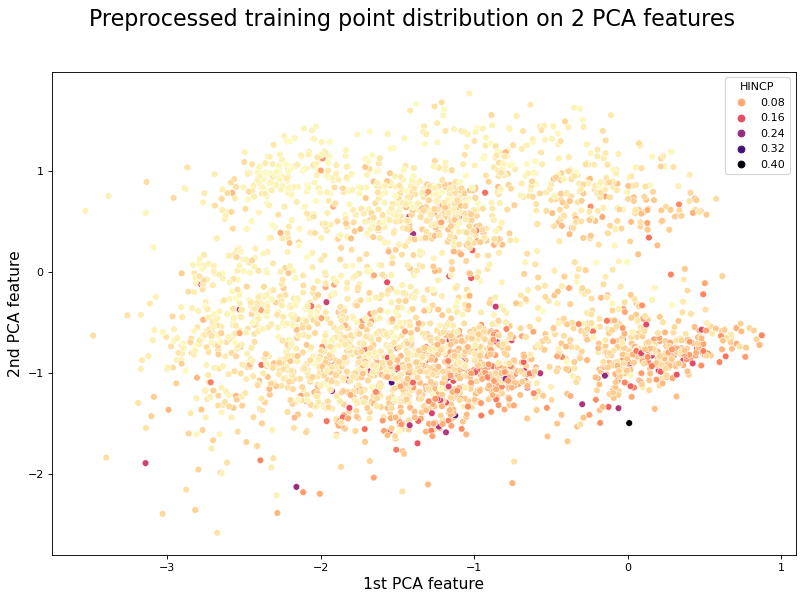

In [16]:
import seaborn as sns

plt.figure(num = None, figsize = (12, 8), dpi = 80)
ax = sns.scatterplot(x = xs, y = ys, hue = ls, palette = "magma_r")
plt.suptitle('Preprocessed training point distribution on 2 PCA features', fontsize = 20)
plt.xlabel("1st PCA feature", fontsize = 14)
plt.ylabel("2nd PCA feature", fontsize = 14)

leg = ax.axes.get_legend()
leg.set_title(label)

#sns.despine()

## Learning algorithm

In [121]:
import json
import progressbar
import numpy as np
import matplotlib.pyplot as plt
from pyspark.mllib.linalg import DenseVector

class RidgeRegression:
    """
    Implementation of the ridge regression algorithm that finds the minimum of the objective function
        via stochastic gradient descent. Since it considers a regression problem, the objective function
        to be minimized is the square loss.
    """
    
    def __init__(self, n_iters = 10, learn_rate = 0.01, reg_factor = 1e-10):
        """
        Constructor of a RidgeRegression object. Initializes it with its hyperparameters.

        Args:
            n_iters (int): Number of iterations for the stochastic gradient descent procedure.
            learn_rate (float): Initial learning rate for the stochastic grandient descent procedure.
            reg_factor (float): Regularization factor for the ridge regression.
        """
        
        self.n_iters = n_iters
        #self.n_iters = n_iters - 1000
        self.learn_rate = learn_rate 
        self.reg_factor = reg_factor
    
    def predict_with_label(self, observation, **kwargs):
        """
        Computes the predicted label and associates it with the real label.
        
        Args:
            observation (LabeledPoint): Data point composed by its feautures and its label.
            weigths (np array of double, optional): Array containig the weights of the linear relationship
                with the features of the data points. If not specified, weight vector of the model is
                used instead.
            
        Returns:
            tuple (float, float): Pair (true label, predicted label) relative to the given data point.
        """
        
        if len(kwargs.keys()) == 0:
            return (observation.label, self.weights.dot(DenseVector(observation.features)))
        else:
            return (observation.label, kwargs['weights'].dot(DenseVector(observation.features)))
    
    def _gradient_summand(self, weights, lp):
        """
        Computes a summand in the gradient formulation of the square loss.
        
        Args:
            weigths (DenseVector): Vector containing the weights learnt by the model.
            lp (LabeledPoint): A single observation composed by its features and its label.
            
        Returns:
            DenseVector: Dot product between the weights vector and the feature vector, minus the
                label and multiplied again for the the feature vector.
        """
        
        return (weights.dot(DenseVector(lp.features)) - lp.label) * lp.features
    
    def fit(self, train_data):
        """
        Trains the model in order to find the best weight vector that minimizes the square loss.
            It does so with stochastic gradient descent procedure.
            
        Args:
            train_data (RDD of LabeledPoints): training set used in order to real the weight vector.
            
        Returns:
            RidgeRegression: object corresponding to the lerant predictor.
        """
        
        n = train_data.count()
        d = len(train_data.take(1)[0].features)
        w = np.zeros(d)
        #w = np.array([])
        
        train_error = np.zeros(self.n_iters)

        bar = progressbar.ProgressBar(maxval = self.n_iters,
                                      widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()
        
        for i in range(self.n_iters):
            labels_and_preds_train = train_data.map(lambda p: self.predict_with_label(p, weights = w))
            train_error[i] = rmse(labels_and_preds_train)

            gradient_sum = train_data.map(lambda lp: DenseVector(self._gradient_summand(w, lp))) \
                            .reduce(lambda x, y: x + y)
            gradient = gradient_sum + (self.reg_factor * w)

            learn_rate_i = self.learn_rate / (n * np.sqrt(i + 1))
            #learn_rate_i = self.learn_rate / (n * np.sqrt(i + 1001))
            w -= learn_rate_i * gradient
            
            bar.update(i + 1)
            
        bar.finish()

        self.weights = w
        self.train_error = train_error

        return self
    
    def predict(self, features):
        """
        Computes the predicted label for a given observation.
        
        Args:
            features (vector of floats): Feature vector of a data point.
            
        Returns:
            float: predicted label relative to the given data point.
        """
        
        return self.weights.dot(DenseVector(features))
    
    def write_on_file(self):
        """
        Writes the properties of the model in order to reload the model in consecutive executions.
        
        Args:
            filename (string): name of the file containing the representation, in JSON,
                of the model.
        """
        
        if not os.path.exists('./models'):
            os.mkdir('./models')
            
        model = dict()
        model['n_iters'] = self.n_iters
        model['learn_rate'] = self.learn_rate
        model['reg_factor'] = self.reg_factor
        model['weights'] = self.weights.tolist()
        model['train_error'] = self.train_error.tolist()
        
        j = json.dumps(model, indent = 4)
        
        with open('./models/model_%d_%g_%g.json' % (self.n_iters, self.learn_rate, self.reg_factor), 'w') as f:
            print(j, file = f)

In [122]:
def squared_error(label, prediction):
    """
    Computes the squared error for a prediction.
        
    Args:
        label (float): True label for this observation.
        prediction (float): Predicted label for this observation.
            
    Returns:
        float: Squared difference between the true label and the predicted label.
    """
        
    return (label - prediction) ** 2

def rmse(labels_and_preds):
    """
    Computes the root mean squared error for an RDD of (true label, predicted label) tuples.
        
    Args:
       labels_and_preds (RDD of (float, float)): RDD of (true label, predicted label) tuples.
           
    Returns:
       float: Square root of the mean of the squared errors of all the tuples in the RDD.
    """
        
    return np.sqrt(labels_and_preds.map(lambda p: squared_error(*p)).mean())

def plot_train_error(model):
    """
    Saves the figure containing the progression of the training error for each iteration of the stochastic gradient
        descent procedure.

    Args:
        train_error (list of floats): List containing, for each iteration, the value of the training RMSE.
    """

    if not os.path.exists('./images'):
        os.mkdir('./images')
    
    #tr = np.array([])
    #tr = np.append(tr, model.train_error)
    
    fig = plt.figure(figsize = (12, 7))
    g = sns.lineplot(x = np.arange(model.n_iters), y = model.train_error, color = 'crimson')
    #g = sns.lineplot(x = np.arange(50, model.n_iters), y = model.train_error[50:], color = 'crimson')
    #g.set(yscale = "log")
    #g.set(xscale = "log")
    
    #plt.plot(np.arange(1, len(tr) + 1), tr)
    
    fig.suptitle('Evolution of training error through iterations', fontsize = 20)
    plt.xlabel('Iteration', fontsize = 14)
    plt.ylabel('Training error', fontsize = 14)
    #plt.show()
    plt.savefig('images/train_error_%d_%g_%g.png' % (model.n_iters, model.learn_rate, model.reg_factor))

In [7]:
from datetime import datetime
import pytz

def print_now():
    tz = pytz.timezone('Europe/Rome')
    time = datetime.now(tz)
    print("Current time =", time.strftime("%d-%m-%y %H:%M:%S"))

Current time = 15-09-20 00:50:23
Training the model with parameters:
	Number of iterations = 3000
	Learning rate = 0.1       
	Regularization factor = 1e-05
...


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.03324971759104793
Training RMSE (USD) = 78036.0
Validation RMSE = 0.03300862035767349
Validation RMSE (USD) = 78016.0
Current time = 15-09-20 23:15:29


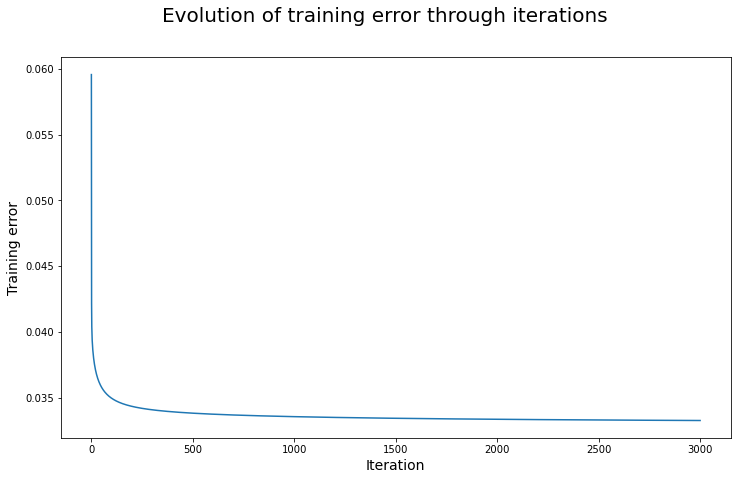

In [131]:
# train the model
n_iters = 3000
reg_factor = 1e-5
learn_rate = 0.1

print_now()
print('Training the model with parameters:\n\tNumber of iterations = {}\n\tLearning rate = {} \
      \n\tRegularization factor = {}\n...'
    .format(n_iters, learn_rate, reg_factor))

model = RidgeRegression(n_iters, learn_rate, reg_factor)
model.fit(parsed_train_data)
model.write_on_file()

print('Training... DONE!')
print('Training RMSE = {}\nTraining RMSE (USD) = {}'.format(model.train_error[-1],
                                                        real_label_standard(model.train_error[-1], label_stats)))

labels_and_preds_val = parsed_val_data.map(lambda p: model.predict_with_label(p))
val_rmse = rmse(labels_and_preds_val)

print('Validation RMSE = {}\nValidation RMSE (USD) = {}'.format(val_rmse,
                                                                real_label_standard(val_rmse, label_stats)))

print_now()

plot_train_error(model)

In [130]:
model.weights

array([ 0.0153428 ,  0.01198365, -0.0151627 ,  0.0041065 , -0.0055861 ,
        0.0075478 ,  0.00297676,  0.0011927 , -0.00766552, -0.00618195,
       -0.00333404,  0.00937981, -0.00099314,  0.00522151,  0.00182422,
       -0.00611842,  0.00021361, -0.00618471,  0.00045368,  0.00167425,
        0.00603616, -0.00709903,  0.00102671, -0.00246104, -0.00396789,
       -0.00251353, -0.00975432,  0.00226279, -0.00678699, -0.0159145 ,
       -0.00283255])

In [12]:
model.write_on_file()

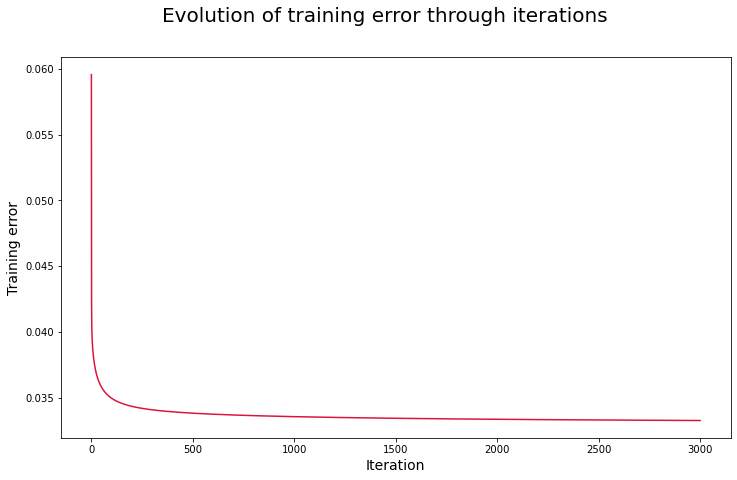

In [169]:
fig = plt.figure(figsize = (12, 7))
g = sns.lineplot(x = np.arange(model.n_iters), y = model.train_error, color = 'crimson')
#g = sns.lineplot(x = np.arange(50, model.n_iters), y = model.train_error[50:], color = 'crimson')
#g.set(yscale = "log")
#g.set(xscale = "log")
fig.suptitle('Evolution of training error through iterations', fontsize = 20)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Training error', fontsize = 14)

plt.savefig('images/train_error_%d_%g_%g.png' % (model.n_iters, model.learn_rate, model.reg_factor))

In [150]:
model.n_iters

3000

In [75]:
out = 1000

predictions_and_labels = [(model.predict_with_label(parsed_test_data.take(out)[i], weights = model.weights)) for i in range(out)]

xs = [(int)(real_label_minmax(predictions_and_labels[i][0], label_stats)) for i in range(len(predictions_and_labels))]
ys = [(int)(real_label_minmax(predictions_and_labels[i][1], label_stats)) for i in range(len(predictions_and_labels))]
ls = [abs(xs[i] - ys[i]) for i in range(len(xs))]

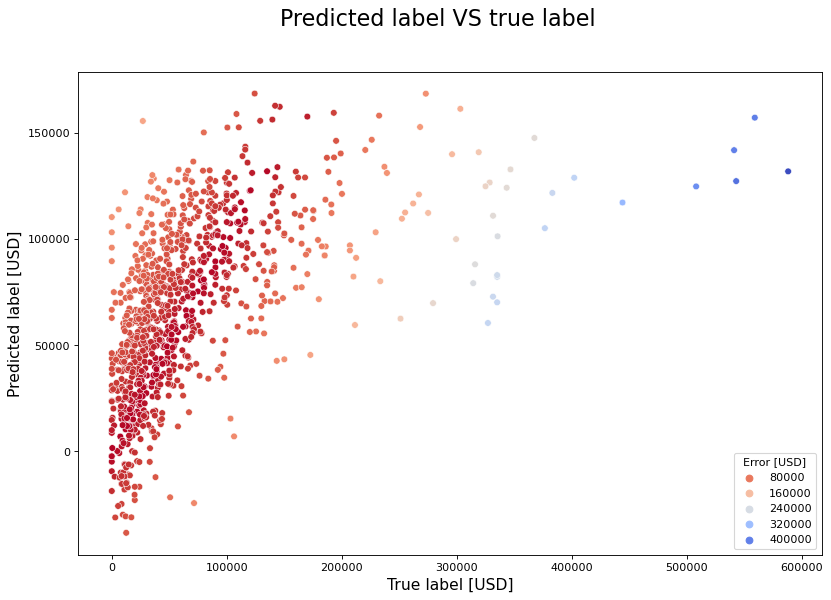

In [197]:
import seaborn as sns

plt.figure(num = None, figsize = (12, 8), dpi = 80)
ax = sns.scatterplot(x = xs, y = ys, hue = ls, palette = "coolwarm_r")
#plt.plot(ys, ys, color = 'black');
plt.suptitle('Predicted label VS true label', fontsize = 20)
plt.xlabel("True label [USD]", fontsize = 14)
plt.ylabel("Predicted label [USD]", fontsize = 14)

leg = ax.axes.get_legend()
leg.set_title("Error [USD]")

### Grid search

Let us now search for the best parameters combinatin. We have 3 different hyperparameters:

- Number of iterations: 500
- Regularization factor: 1e-5, 1e-10
- Learning rate: via previous testing, we saw that csi = 1 introduce to numerical problems, so we may want to use smaller values. In the specific case, we may want to test for 0.01, 1e-5

In [125]:
def grid_search(train_set, val_set, n_iters_params, reg_factor_params, learn_rate_params):
    """
    Performs grid search in order to find the best hyperparameters.

    Args:
        train_set (RDD of LabeledPoints): Training set used to be used to train the model.
        val_set (RDD of LabeledPoints): Validation set used to be used to evaluate the model.
        n_iters_params (list of int): list of parameters for the number of iterations of the stochastic
            gradient descent procedure.
        reg_factor_params (list of float): list of parameters for the regularization factor of ridge
            regression.
        learn_rate_params (list of float): list of parameters for the learning rate of the stochastic
            gradient descent procedure.

    Returns:
        RidgeRegression: ridge regression model with the lowest rmse value on the validation set.
    """
    print('Performing grid search...')

    best_model = None
    best_rmse_val = float('inf')

    for n_iters in n_iters_params:
        for reg_factor in reg_factor_params:
            for learn_rate in learn_rate_params:                                
                print('Training the model with parameters:\n\tNumber of iterations: {}\n\tRegularization factor: {} \
                    \n\tLearning rate: {}'.format(n_iters, reg_factor, learn_rate))
                model = RidgeRegression(n_iters = n_iters, learn_rate = learn_rate, reg_factor = reg_factor)
                model.fit(parsed_train_data)
                model.write_on_file()
                
                print('Training... DONE!')
                print('Training RMSE = {}'.format(model.train_error[-1]))

                # Evaluate the model on the validation set
                labels_and_preds_val = parsed_val_data.map(lambda p: model.predict_with_label(p))
                rmse_val = rmse(labels_and_preds_val)

                print('Validation RMSE = {}'.format(rmse_val))

                plot_train_error(model)

                if rmse_val < best_rmse_val:
                    best_model = model
                    best_rmse_val = rmse_val

    return best_model

Performing grid search...
Training the model with parameters:
	Number of iterations: 5
	Regularization factor: 1e-05                     
	Learning rate: 0.001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.05895004220826204
Validation RMSE = 0.05850206377676358
Training the model with parameters:
	Number of iterations: 5
	Regularization factor: 1e-05                     
	Learning rate: 1e-05


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.0595778691088772
Validation RMSE = 0.05922980606921093
Training the model with parameters:
	Number of iterations: 5
	Regularization factor: 1e-10                     
	Learning rate: 0.001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.058950042208262034
Validation RMSE = 0.05850206377676357
Training the model with parameters:
	Number of iterations: 5
	Regularization factor: 1e-10                     
	Learning rate: 1e-05


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.0595778691088772
Validation RMSE = 0.05922980606921093


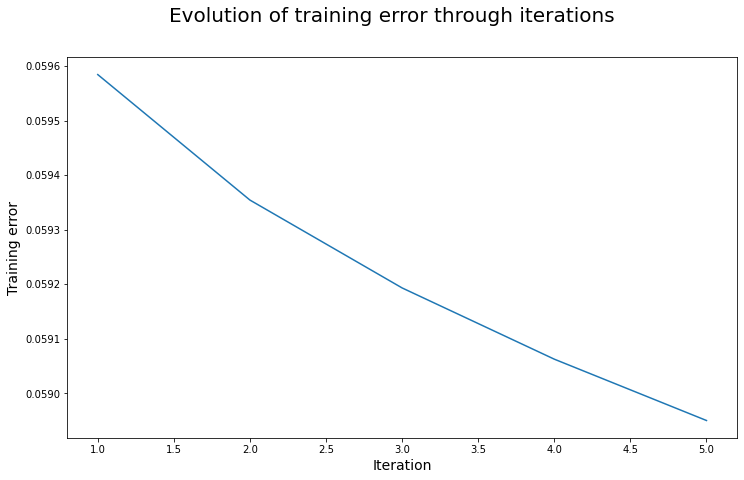

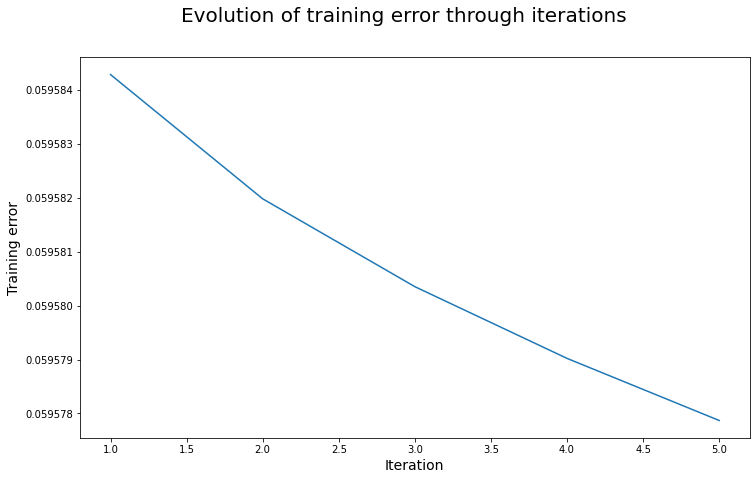

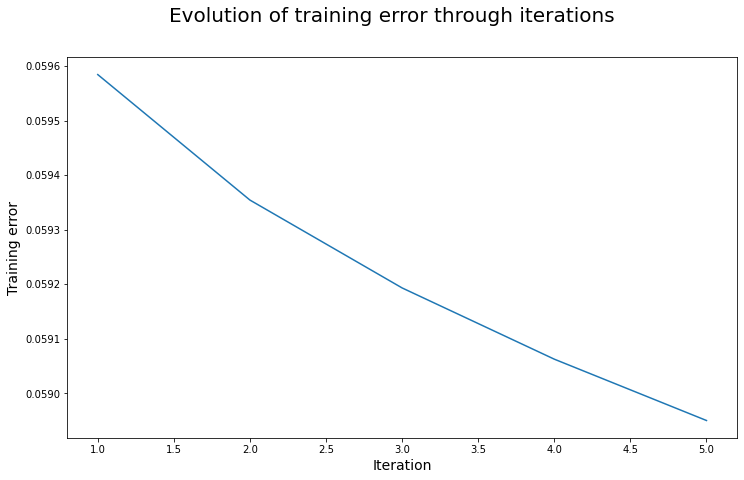

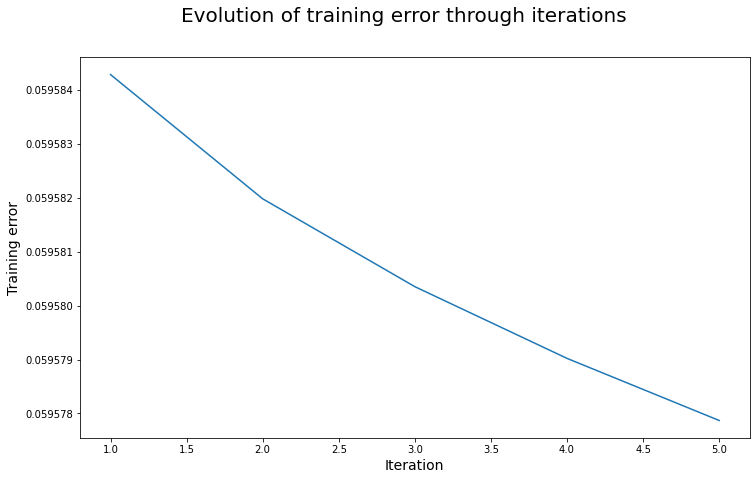

In [126]:
n_iters_params = [5]
reg_factor_params = [1e-5, 1e-10]
learn_rate_params = [0.001, 1e-5]

best_model = grid_search(parsed_train_data, parsed_val_data, n_iters_params, reg_factor_params, learn_rate_params)

In [244]:
from pyspark.mllib.regression import LinearRegressionWithSGD

new_model = LinearRegressionWithSGD.train(parsed_train_data, iterations = n_iters, step = learn_rate,
                                          regParam = reg_factor, regType = 'l2', intercept = True)

In [245]:
new_model.weights

DenseVector([-0.1384, 0.0969, 0.0224, -0.0053, 0.0268, -0.0273, -0.051, -0.0139, -0.0449, 0.0195, -0.0561, -0.0157, 0.049, -0.051, 0.0406, 0.0373, -0.0413, 0.0451, -0.0133, -0.0601, -0.007, 0.0413, 0.006, -0.0031, 0.065, -0.0007, 0.1287, -0.081, 0.0797, 0.0675, -0.0105])

In [246]:
new_model.intercept

0.8615679743970928

In [247]:
labelsAndPreds = parsed_val_data.map(lambda p: (p.label, new_model.predict(p.features)))
new_val_rmse = rmse(labelsAndPreds)
print(new_val_rmse)

0.12853103993228165


## Crossvalidation

In [ ]:
def cross_validation(dataset, n_iters, learn_rate, reg_factor, k):
    """
    Performs cross-validation in order to compute the cross-validated score of the model associated with
        the given parameters.
        
    Args:
        dataset (RDD of LabeledPoints): RDD containing the dataset.
        n_iters (int): Number of iterations for the stochastic gradient descent procedure.
        learn_rate (float): Initial learning rate for the stochastic grandient descent procedure.
        reg_factor (float): Regularization factor for the ridge regression.
        k (int): Number of folds in the k-fold cross-validation.
            
    Returns:
        Float: cross-validated score.
    """

## Tree regression

In [253]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainRegressor(parsed_train_data, categoricalFeaturesInfo = {},
                                    impurity = 'variance', maxDepth = 5, maxBins = 32)

# Evaluate model on test instances and compute test error
predictions = model.predict(parsed_test_data.map(lambda x: x.features))
labelsAndPredictions = parsed_test_data.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(parsed_test_data.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression tree model:')
print(model.toDebugString())

# Save and load model
model.save(sc, "target/tmp/myDecisionTreeRegressionModel")
sameModel = DecisionTreeModel.load(sc, "target/tmp/myDecisionTreeRegressionModel")

Test Mean Squared Error = 0.0010783740011505968
Learned regression tree model:
DecisionTreeModel regressor of depth 10 with 1985 nodes
  If (feature 2 <= -0.6158816544855754)
   If (feature 1 <= -1.383534903255503)
    If (feature 1 <= -1.7936838409782334)
     If (feature 2 <= -0.9818225975017791)
      If (feature 1 <= -2.2007434029287087)
       If (feature 2 <= -1.6271537911350773)
        If (feature 8 <= 0.6926914035267133)
         If (feature 1 <= -2.5512662800669466)
          If (feature 25 <= -0.7509227681602617)
           If (feature 2 <= -1.8012876682878094)
            Predict: 0.33973845490266713
           Else (feature 2 > -1.8012876682878094)
            Predict: 0.02925437369950279
          Else (feature 25 > -0.7509227681602617)
           If (feature 29 <= -0.4763289495087394)
            Predict: 0.047260573985064995
           Else (feature 29 > -0.4763289495087394)
            Predict: 0.03706507117367486
         Else (feature 1 > -2.5512662800669466)
       

In [254]:
labelsAndPredictions.take(1)

[(0.05525246827853273, 0.06540598366386657)]

In [255]:
new_val_rmse = rmse(labelsAndPredictions)
print(new_val_rmse)

0.032838605347222


In [258]:
out = 1000

labels_and_predictions = labelsAndPredictions.take(out)

xs = [(int)(real_label_minmax(labels_and_predictions[i][0], label_stats)) for i in range(len(labels_and_predictions))]
ys = [(int)(real_label_minmax(labels_and_predictions[i][1], label_stats)) for i in range(len(labels_and_predictions))]
ls = [abs(xs[i] - ys[i]) for i in range(len(xs))]

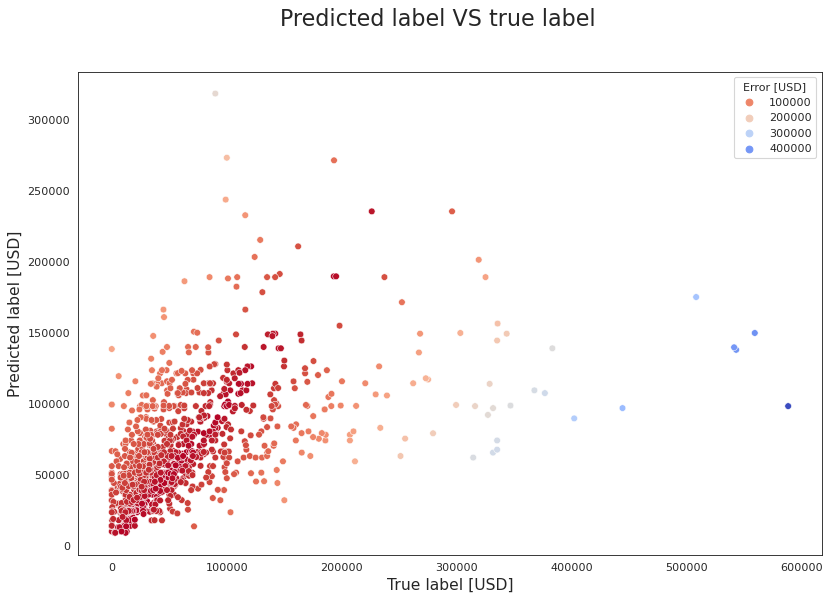

In [264]:
#with sns.axes_style("whitegrid"):
with sns.axes_style("white"):
    plt.figure(num = None, figsize = (12, 8), dpi = 80)

    ax = sns.scatterplot(x = xs, y = ys, hue = ls, palette = "coolwarm_r")
    #plt.plot(ys, ys, color = 'black');
    plt.suptitle('Predicted label VS true label', fontsize = 20)
    plt.xlabel("True label [USD]", fontsize = 14)
    plt.ylabel("Predicted label [USD]", fontsize = 14)

    leg = ax.axes.get_legend()
    leg.set_title("Error [USD]")